# DLS Assignment - 4

### This assignment was discussed with Tejasram Ramesh and Ramki Ramamurthy.

### For this assignment I referred the following resources:
  #### 1) Deep Learning with Python - by Francois Cholet
  #### 2) https://www.youtube.com/watch?v=zHTe9ehehX8
  #### 3) https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model
  #### 4) https://www.tensorflow.org/guide/core/matrix_core
  #### 5) https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
  #### 6) https://www.tensorflow.org/api_docs/python/tf/compat/v1/initializers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import timeit
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Allocating and Checking the GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9996129950000068
GPU (s):
0.04285065199999849
GPU speedup over CPU: 70x


### Loading the MNIST Dataset

In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(train_images, train_labels) , (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
#Lets look at the training data
print("Training Images Shape: ",train_images.shape)
print("Training Labels: ",train_labels)


#Lets look at the testing data
print("Testing Images Shape: ",test_images.shape)
print("Testing Labels: ",test_labels)

Training Images Shape:  (60000, 28, 28)
Training Labels:  [5 0 4 ... 5 6 8]
Testing Images Shape:  (10000, 28, 28)
Testing Labels:  [7 2 1 ... 4 5 6]


### Normalizing the Images

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images/=255
test_images/=255

### Creating the Baseline Model

In [ ]:
baseline = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(1024, activation='relu', name='first_layer',kernel_initializer=keras.initializers.GlorotNormal()),
    layers.Dense(1024, activation='relu', name='second_layer',kernel_initializer=keras.initializers.GlorotNormal()),
    layers.Dense(1024, activation='relu', name='third_layer',kernel_initializer=keras.initializers.GlorotNormal()),
    layers.Dense(1024, activation='relu', name='fourth_layer',kernel_initializer=keras.initializers.GlorotNormal()),
    layers.Dense(1024, activation='relu', name="fifth_layser",kernel_initializer=keras.initializers.GlorotNormal()),
    layers.Dense(10, name='output' ,activation='softmax',kernel_initializer=keras.initializers.GlorotNormal())
])
print(baseline.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 first_layer (Dense)         (None, 1024)              803840    
                                                                 
 second_layer (Dense)        (None, 1024)              1049600   
                                                                 
 third_layer (Dense)         (None, 1024)              1049600   
                                                                 
 fourth_layer (Dense)        (None, 1024)              1049600   
                                                                 
 fifth_layser (Dense)        (None, 1024)              1049600   
                                                                 
 output (Dense)              (None, 10)                1

In [ ]:
baseline.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

### Training the Baseline

In [ ]:
history_baseline = baseline.fit(train_images , train_labels ,epochs = 30, batch_size = 256)

Epoch 1/30
235/235 [==============================] - 2s 6ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9973
Epoch 2/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9977
Epoch 3/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9974
Epoch 4/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9976
Epoch 5/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9976
Epoch 6/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9977
Epoch 7/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9982
Epoch 8/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9990
Epoch 9/30
235/235 [============================

In [ ]:
evaluation = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.9856


### Saving the Baseline Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/DLS_Assignments/Models/assign4_part1_baseline.h5'

In [ ]:
#model_path = '/content/drive/MyDrive/DLS_Assignments/Models/assign4_part1_baseline.h5'
baseline.save(model_path)

### Loading the saved model

In [ ]:
baseline = keras.models.load_model(model_path)

### Applying SVD on weight matrices of every layer

In [ ]:
accuracies=[]

In [ ]:
s_1 , U_1, V_1 = tf.linalg.svd(baseline.get_layer(index=1).get_weights()[0])
s_2 , U_2, V_2 = tf.linalg.svd(baseline.get_layer(index=2).get_weights()[0])
s_3 , U_3, V_3 = tf.linalg.svd(baseline.get_layer(index=3).get_weights()[0])
s_4 , U_4, V_4 = tf.linalg.svd(baseline.get_layer(index=4).get_weights()[0])
s_5 , U_5, V_5 = tf.linalg.svd(baseline.get_layer(index=5).get_weights()[0])



S_1 = tf.linalg.diag(s_1)
S_2 = tf.linalg.diag(s_2)
S_3 = tf.linalg.diag(s_3)
S_4 = tf.linalg.diag(s_4)
S_5 = tf.linalg.diag(s_5)



V_1T = tf.transpose(V_1)
V_2T = tf.transpose(V_2)
V_3T = tf.transpose(V_3)
V_4T = tf.transpose(V_4)
V_5T = tf.transpose(V_5)


bias1 = baseline.get_layer(index=1).get_weights()[1]
bias2 = baseline.get_layer(index=2).get_weights()[1]
bias3 = baseline.get_layer(index=3).get_weights()[1]
bias4 = baseline.get_layer(index=4).get_weights()[1]
bias5 = baseline.get_layer(index=5).get_weights()[1]

#### For D=10

In [ ]:
r=10
W1 = tf.matmul(tf.matmul(U_1[:, :r], S_1[:r, :r]), V_1T[:r, :])
W2 = tf.matmul(tf.matmul(U_2[:, :r], S_2[:r, :r]), V_2T[:r, :])
W3 = tf.matmul(tf.matmul(U_3[:, :r], S_3[:r, :r]), V_3T[:r, :])
W4 = tf.matmul(tf.matmul(U_4[:, :r], S_4[:r, :r]), V_4T[:r, :])
W5 = tf.matmul(tf.matmul(U_5[:, :r], S_5[:r, :r]), V_5T[:r, :])


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_10 = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 1.7336 - sparse_categorical_accuracy: 0.5153


In [ ]:
accuracies.append(test_10[1])

#### For D=20

In [ ]:
#baseline = keras.models.load_model(model_path)

In [ ]:
r=20
W1 = tf.matmul(tf.matmul(U_1[:, :r], S_1[:r, :r]), V_1T[:r, :])
W2 = tf.matmul(tf.matmul(U_2[:, :r], S_2[:r, :r]), V_2T[:r, :])
W3 = tf.matmul(tf.matmul(U_3[:, :r], S_3[:r, :r]), V_3T[:r, :])
W4 = tf.matmul(tf.matmul(U_4[:, :r], S_4[:r, :r]), V_4T[:r, :])
W5 = tf.matmul(tf.matmul(U_5[:, :r], S_5[:r, :r]), V_5T[:r, :])


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_20 = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.9116


In [ ]:
accuracies.append(test_20[1])

#### For D=50

In [ ]:
#baseline = keras.models.load_model(model_path)

In [ ]:
r=50
W1 = tf.matmul(tf.matmul(U_1[:, :r], S_1[:r, :r]), V_1T[:r, :])
W2 = tf.matmul(tf.matmul(U_2[:, :r], S_2[:r, :r]), V_2T[:r, :])
W3 = tf.matmul(tf.matmul(U_3[:, :r], S_3[:r, :r]), V_3T[:r, :])
W4 = tf.matmul(tf.matmul(U_4[:, :r], S_4[:r, :r]), V_4T[:r, :])
W5 = tf.matmul(tf.matmul(U_5[:, :r], S_5[:r, :r]), V_5T[:r, :])


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_50 = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9822


In [ ]:
accuracies.append(test_50[1])

#### For D=100

In [ ]:
#baseline = keras.models.load_model(model_path)

In [ ]:
r=100
W1 = tf.matmul(tf.matmul(U_1[:, :r], S_1[:r, :r]), V_1T[:r, :])
W2 = tf.matmul(tf.matmul(U_2[:, :r], S_2[:r, :r]), V_2T[:r, :])
W3 = tf.matmul(tf.matmul(U_3[:, :r], S_3[:r, :r]), V_3T[:r, :])
W4 = tf.matmul(tf.matmul(U_4[:, :r], S_4[:r, :r]), V_4T[:r, :])
W5 = tf.matmul(tf.matmul(U_5[:, :r], S_5[:r, :r]), V_5T[:r, :])


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_100 = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9848


In [ ]:
accuracies.append(test_100[1])

#### For D=200

In [ ]:
#baseline = keras.models.load_model(model_path)

In [ ]:
r=200
W1 = tf.matmul(tf.matmul(U_1[:, :r], S_1[:r, :r]), V_1T[:r, :])
W2 = tf.matmul(tf.matmul(U_2[:, :r], S_2[:r, :r]), V_2T[:r, :])
W3 = tf.matmul(tf.matmul(U_3[:, :r], S_3[:r, :r]), V_3T[:r, :])
W4 = tf.matmul(tf.matmul(U_4[:, :r], S_4[:r, :r]), V_4T[:r, :])
W5 = tf.matmul(tf.matmul(U_5[:, :r], S_5[:r, :r]), V_5T[:r, :])


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_200 = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9850


In [ ]:
accuracies.append(test_200[1])

#### For D=Full

In [ ]:
#baseline = keras.models.load_model(model_path)

In [ ]:
#r=50
W1 = tf.matmul(tf.matmul(U_1, S_1), V_1T)
W2 = tf.matmul(tf.matmul(U_2, S_2), V_2T)
W3 = tf.matmul(tf.matmul(U_3, S_3), V_3T)
W4 = tf.matmul(tf.matmul(U_4, S_4), V_4T)
W5 = tf.matmul(tf.matmul(U_5, S_5), V_5T)


baseline.get_layer(index=1).set_weights([W1,bias1])
baseline.get_layer(index=2).set_weights([W2,bias2])
baseline.get_layer(index=3).set_weights([W3,bias3])
baseline.get_layer(index=4).set_weights([W4,bias4])
baseline.get_layer(index=5).set_weights([W5,bias5])

In [ ]:
test_full = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.9856


In [ ]:
accuracies.append(test_full[1])

### Comparing the test accuracies for different values of D

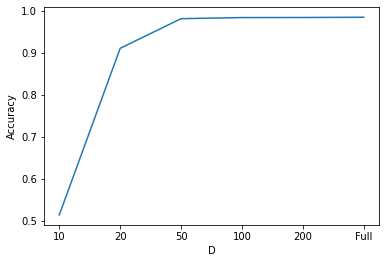

In [ ]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_ylabel("Accuracy")
ax.set_xlabel("D")
x_axis = [0,10,20,50,100,200,'Full']
ax.set_xticklabels(x_axis)
plt.show()

In [ ]:
accuracies

[0.5152999758720398,
 0.9115999937057495,
 0.982200026512146,
 0.9847999811172485,
 0.9850000143051147,
 0.9855999946594238]